# Importing Libraries

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293633 sha256=f4e9b28018a30eba4ec991fdca38de7b271526e57568d9418a122e1446d8c8e1
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=08a8a00d451ef5801e23fb9677541c4e448af9ca353ac38a2a89041936c11097
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 17.4 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")
import ta
import visualkeras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from tqdm import tqdm
from tqdm.keras import TqdmCallback

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline


2024-07-21 23:35:15.170392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 23:35:15.170524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 23:35:15.331167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download data -> create dataframe

In [5]:
import yfinance as yf

ticker = "GS"
data = yf.download(ticker, start="2000-01-01", end="2024-01-01")

display(data.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,94.1875,94.3750,87.750,88.3125,63.294113,1822600
2000-01-04,87.0000,87.5000,82.250,82.7500,59.307468,1647700
2000-01-05,80.8750,81.8750,78.375,78.8750,56.530216,1516600
2000-01-06,78.6250,84.5000,78.625,82.2500,58.949104,1845100
2000-01-07,83.0625,83.1875,79.875,82.5625,59.173065,1127400


# Visualize the data

In [6]:
data.insert(loc=0, column='Date', value=data.index)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-01-03,2000-01-03,94.1875,94.3750,87.750,88.3125,63.294113,1822600
2000-01-04,2000-01-04,87.0000,87.5000,82.250,82.7500,59.307468,1647700
2000-01-05,2000-01-05,80.8750,81.8750,78.375,78.8750,56.530216,1516600
2000-01-06,2000-01-06,78.6250,84.5000,78.625,82.2500,58.949104,1845100
2000-01-07,2000-01-07,83.0625,83.1875,79.875,82.5625,59.173065,1127400


In [7]:
data.reset_index(drop=True, inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,94.1875,94.3750,87.750,88.3125,63.294113,1822600
1,2000-01-04,87.0000,87.5000,82.250,82.7500,59.307468,1647700
2,2000-01-05,80.8750,81.8750,78.375,78.8750,56.530216,1516600
3,2000-01-06,78.6250,84.5000,78.625,82.2500,58.949104,1845100
4,2000-01-07,83.0625,83.1875,79.875,82.5625,59.173065,1127400


> Close Price

In [8]:
fig = px.line(data, x='Date', y='Close', title='Closing Price', color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_xaxes(title_text='Date', tickangle=-80)
fig.update_yaxes(title_text='Closing Price')
fig.show()

> Trading Volume

In [9]:
fig = px.line(data, x='Date', y='Volume', title='Trading Volume', color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_xaxes(title_text='Date', tickangle=-80)
fig.show()

> Close Price Difference

In [10]:
# column for close price fifference
data['Close Price Diff'] = data['Close'].diff()

In [11]:
wf = go.Waterfall(
    x=data['Date'],
    y=data['Close Price Diff'],
    decreasing={'marker': {'color': 'red'}},
    increasing={'marker': {'color': 'lime'}}
)

layout = go.Layout(
    title='Closing Price Diff Waterfall',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price Diff'),
    xaxis_tickangle=45
)

fig = go.Figure(data=[wf], layout=layout)
fig.show()

# Preprocess data

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6037 entries, 0 to 6036
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              6037 non-null   datetime64[ns]
 1   Open              6037 non-null   float64       
 2   High              6037 non-null   float64       
 3   Low               6037 non-null   float64       
 4   Close             6037 non-null   float64       
 5   Adj Close         6037 non-null   float64       
 6   Volume            6037 non-null   int64         
 7   Close Price Diff  6036 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 377.4 KB


In [13]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Price Diff
count,6037,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000,6.037000e+03,6036.000000
mean,2012-01-02 03:12:00.954116096,175.943605,178.027697,173.855580,175.970511,148.004165,5.166473e+06,0.049281
min,2000-01-03 00:00:00,54.000000,54.540001,47.410000,52.000000,39.992195,3.971000e+05,-26.540009
25%,2006-01-04 00:00:00,106.900002,108.375000,105.300003,107.059998,80.883530,2.446000e+06,-1.600006
50%,2011-12-30 00:00:00,163.910004,165.729996,162.160004,163.850006,131.883591,3.450400e+06,0.040001
75%,2017-12-29 00:00:00,214.449997,216.860001,212.009995,214.009995,182.104462,5.429300e+06,1.719994
max,2023-12-29 00:00:00,423.119995,426.160004,413.760010,423.850006,392.987793,1.145907e+08,26.490005
std,NaN,81.089139,81.746239,80.411780,81.085161,81.629099,5.949691e+06,3.608536


In [14]:
data.isnull().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Close Price Diff    1
dtype: int64

In [15]:
# get the values of close column in new dataframe
dataset = data.filter(['Close']).values

# number of rows for training
train_len = int(np.ceil(len(dataset) * .8))
train_len

4830

In [16]:
# scaling data
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)

scaled_data[:5]

array([[0.09765362],
       [0.08269463],
       [0.07227377],
       [0.08135001],
       [0.0821904 ]])

In [17]:
train = scaled_data[0:int(train_len), :]

# Creating Train Data

In [18]:
time_step = 60

x_train = [] # store input sequences
y_train = [] # store corresponding output values

for i in tqdm(range(time_step, len(train)), desc="Processing"):
    x_train.append(train[i-time_step:i, 0])
    y_train.append(train[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

Processing: 100%|██████████| 4770/4770 [00:00<00:00, 473153.68it/s]


In [19]:
# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4770, 60, 1)

# Create Test Data

In [20]:
test = scaled_data[train_len-time_step:, :]

# create x_test and y_test
x_test = []
y_test =  dataset[train_len:, :]

for i in tqdm(range(time_step, len(test)), desc="Processing"):
    x_test.append(test[i-time_step:i, 0])

Processing: 100%|██████████| 1207/1207 [00:00<00:00, 523691.42it/s]


In [21]:
# convert to numpy array
x_test = np.array(x_test)
y_test = np.array(y_test)

In [22]:
# reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
x_test.shape

(1207, 60, 1)

# LSTM Model

In [23]:
def build_compile_model():
    # build the LSTM model
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

model = build_compile_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,101 (1.08 MB)

 Trainable params: 282,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

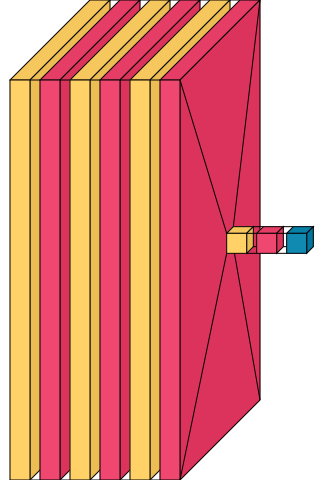

In [24]:
visualkeras.layered_view(model)

In [25]:
# Train the model
hist = model.fit(x_train, y_train,validation_data=(x_test, y_test), batch_size=64, epochs=10, verbose=0, callbacks=[TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

  0%|          | 0.00/75.0 [00:00<?, ?batch/s]

In [26]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


> **Evaluation**

In [27]:
def plot_training_metrics(history):
    epochs = list(range(1, len(history['loss']) + 1))
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    fig = make_subplots(rows=2, cols=2)

    # Add traces to each subplot
    fig.add_trace(go.Scatter(x=epochs, y=loss, mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation Loss'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=accuracy, mode='lines', name='Training Accuracy'), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines', name='Validation Accuracy'), row=2, col=2)

    fig.update_xaxes(title_text='Epochs', row=1, col=1)
    fig.update_xaxes(title_text='Epochs', row=1, col=2)
    fig.update_xaxes(title_text='Epochs', row=2, col=1)
    fig.update_xaxes(title_text='Epochs', row=2, col=2)

    fig.update_yaxes(title_text='Training Loss', row=1, col=1)
    fig.update_yaxes(title_text='Validation Loss', row=1, col=2)
    fig.update_yaxes(title_text='Training Accuracy', row=2, col=1)
    fig.update_yaxes(title_text='Validation Accuracy', row=2, col=2)

    fig.update_layout(title_text='Training Metrics', height=600, width=1200, template='plotly_dark')

    fig.show()

plot_training_metrics(hist.history)

In [28]:
from sklearn.metrics import mean_squared_error,r2_score

r2Score_test = r2_score(y_test, predictions)
print('test R2 Score: %.2f ' % (r2Score_test))



test R2 Score: 0.95 


In [29]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

15.926834245795279

> **Prediction Plot**

In [30]:
# Plot the data
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions

# Create traces for the plot
trace1 = go.Scatter(x=train.index, y=train['Close'], mode='lines', name='Train')
trace2 = go.Scatter(x=valid.index, y=valid['Close'], mode='lines', name='Val')
trace3 = go.Scatter(x=valid.index, y=valid['Predictions'], mode='lines', name='Predictions')

# Layout of the plot
layout = go.Layout(
    title='Model',
    xaxis=dict(title='Date', tickformat='%Y-%m-%d', type='date'),
    yaxis=dict(title='Close Price USD ($)'),
    legend=dict(x=0.02, y=0.98)
)

# Create figure and add traces
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show plot
fig.show()
